In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ip-project-data/mango_ripeness_tensordataset.pt


In [69]:
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

In [48]:
datasets = torch.load("/kaggle/input/ip-project-data/mango_ripeness_tensordataset.pt")
data = datasets['data']
labels = datasets['labels']

print(len(data))   # shape : 64*64*249
print(len(labels))

160
160


/tmp/ipykernel_30/2357170278.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  datasets = torch.load("/kaggle/input/ip-project-data/mango_ripeness_tensordataset.pt")


In [49]:
# Hyperspectral Dataset class
class HyperspectralDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data  # Direct tensor data
        self.labels = labels  # Direct tensor labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].float()  
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [50]:
# Define custom transformations separately for training and validation
class RandomHorizontalFlip3D:
    def __call__(self, img):
        if torch.rand(1) < 0.5:
            return torch.flip(img, dims=[2])  # Flip along width
        return img

class RandomRotation3D:
    def __call__(self, img):
        angle = torch.randint(-10, 10, (1,)).item()  # Random rotation angle
        return transforms.functional.rotate(img, angle)

data_transforms = {
    'train': transforms.Compose([
        RandomHorizontalFlip3D(),
        RandomRotation3D(),
        transforms.Normalize(mean=[0] * 249, std=[1] * 249)
    ]),
    'val': transforms.Compose([
        transforms.Normalize(mean=[0] * 249, std=[1] * 249)
    ]),
}

In [51]:
data = data.permute(0, 3, 1, 2)  # Converts data to [num_samples, 249, 64, 64]
#list to store augmented samples
augmented_data = []
augmented_labels = []

# Number of duplicates per sample to increase dataset size
num_duplicates = 3  

# Apply transformations and add duplicates
for i in range(len(data)):
    for _ in range(num_duplicates):
        img = data[i]
        label = labels[i]
        # Apply transformations to create a new augmented image
        img_transformed = data_transforms['train'](img)
        augmented_data.append(img_transformed)
        augmented_labels.append(label)

# Convert the augmented data and labels to tensors
augmented_data = torch.stack(augmented_data)
augmented_labels = torch.tensor(augmented_labels)


In [52]:
# print(augmented_data.shape)
print(len(augmented_data))
print(len(augmented_labels))

# torch.Size([480, 249, 64, 64])
# 480
# 480

480
480


In [53]:
# train and validation datasets with their specific transformations
train_dataset = HyperspectralDataset(augmented_data, augmented_labels, transform=None)
val_dataset = HyperspectralDataset(augmented_data, augmented_labels, transform=None)


# Split the data into training and validation data 
train_size = int(0.8 * len(augmented_data))
val_size = len(augmented_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# prepare the data for model training 
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)


In [54]:
print(len(train_data))
print(len(val_data))

# Accessing a sample from train_data
sample_idx = 1  # Choose an index to inspect
train_sample, train_label = train_data[sample_idx]

print("Train Sample Shape:", train_sample.shape)
print("Train Label:", train_label)

384
96
Train Sample Shape: torch.Size([249, 64, 64])
Train Label: tensor(2)


In [55]:
# Customize model with Resnet50 and transformer layer
class TransRes(nn.Module):
    def __init__(self, in_channels=249, out_channels=64, num_classes=3):
        super(TransRes, self).__init__()
        
        # ResNet-50 as the initial feature extractor
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Identity()  # Remove fully connected layer to get feature map output

        # Transformer Encoder Layer
        d_model = 2048  # ResNet-50 outputs 2048 channels at the last layer
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=4)

        # Positional encoding (Assume 16 tokens for the sequence)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 16, 2048))  

        # Normalization layer
        self.norm = nn.LayerNorm(normalized_shape=4096)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.1)  # After transformer and residual connection
        self.dropout2 = nn.Dropout(p=0.1)  # Before the final classifier

        # linear layer after encoder layer
        self.linear1 = nn.Linear(4096, 512)
        # Final classification layer
        self.classifier  = nn.Linear(512 , num_classes)
        
    def forward(self, x):
        # Input shape: [16, 249, 64, 64]
        # input through ResNet-50 backbone to get feature map
        features = self.resnet(x)  # Shape: [16, 2048]

        # Residual connection: Save initial ResNet features for later
        resnet_features = features  # Shape: [16, 2048]

        # Reshape features for the Transformer Encoder (sequence_length, batch_size, features)
        features = features.unsqueeze(1).permute(1, 0, 2)  # Shape: [1, 16, 2048]

        # Add positional encoding to features
        features = features + self.positional_encoding   # shape : [1, 16, 2048]

        # Encode features using Transformer Encoder
        encoded_features = self.transformer_encoder(features)  # Shape: [1, 16, 2048]

        # Global average pooling across the sequence length (H*W)
        encoded_features = encoded_features.mean(dim=0)  # Shape: [16, 2048]

         # Concatenate ResNet and Transformer features
        combined_features = torch.cat((resnet_features, encoded_features), dim=1)  # Shape: [batch_size, 4096]

        # Normalize the combined features
        # combined_features = self.norm(combined_features)  # Shape: [batch_size, 4096]

        combined_features = self.dropout1(combined_features)  # it will make 10% parameter 0 . Shape :[batch_size , 4096]

        output = self.linear1(combined_features)     # shape : [16*512]

        # output = self.dropout2(output)          # it will make 10% parameter 0 . Shape :[batch_size , 4096]

        # Classification layer
        final_output = self.classifier(output)  # Shape: [16, 3]

        return output

In [56]:

# Instantiate the model, criterion, and optimizer
model = TransRes(in_channels=249, out_channels=64, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [60]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize metric objects for each metric, specifying the task type and number of classes
accuracy_metric = MulticlassAccuracy(num_classes=3).to(device)
precision_metric = MulticlassPrecision(num_classes=3, average='macro').to(device)
recall_metric = MulticlassRecall(num_classes=3, average='macro').to(device)
f1_metric = MulticlassF1Score(num_classes=3, average='macro').to(device)

In [61]:
# Training function with tqdm for progress
# Training function
def train_model(model, criterion, optimizer, train_loader, num_epochs=25):
    # For storing metric values
    metrics_history = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'loss': []
    }

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_samples = 0

        # Epoch metrics
        epoch_accuracy = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)

                # Get predictions
                _, preds = torch.max(outputs, 1)

                # Calculate loss
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Accumulate loss
                running_loss += loss.item()

                # Update metrics for batch
                batch_accuracy = accuracy_metric(preds, labels)
                batch_precision = precision_metric(preds, labels)
                batch_recall = recall_metric(preds, labels)
                batch_f1 = f1_metric(preds, labels)

                # Update epoch metrics
                epoch_accuracy += batch_accuracy
                epoch_precision += batch_precision
                epoch_recall += batch_recall
                epoch_f1 += batch_f1
                total_samples += labels.size(0)

                # Update the progress bar with batch metrics
                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1),
                                   accuracy=batch_accuracy.item(),
                                   precision=batch_precision.item(),
                                   recall=batch_recall.item(),
                                   f1_score=batch_f1.item())

        # Average epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = epoch_accuracy / len(train_loader)
        epoch_precision = epoch_precision / len(train_loader)
        epoch_recall = epoch_recall / len(train_loader)
        epoch_f1 = epoch_f1 / len(train_loader)

        # Store metrics
        metrics_history['loss'].append(epoch_loss)
        metrics_history['accuracy'].append(epoch_accuracy.item())
        metrics_history['precision'].append(epoch_precision.item())
        metrics_history['recall'].append(epoch_recall.item())
        metrics_history['f1_score'].append(epoch_f1.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Loss: {epoch_loss:.4f}, "
              f"Accuracy: {epoch_accuracy:.4f}, Precision: {epoch_precision:.4f}, "
              f"Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}")

    return metrics_history
    

In [62]:
# Train the model with progress display
metrics_history  = train_model(model, criterion, optimizer, train_loader, num_epochs=100)

Epoch 1/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 1/100: Loss: 2.0790, Accuracy: 0.3720, Precision: 0.2525, Recall: 0.3720, F1 Score: 0.2604


Epoch 2/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 2/100: Loss: 1.3098, Accuracy: 0.3835, Precision: 0.3030, Recall: 0.3835, F1 Score: 0.2695


Epoch 3/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 3/100: Loss: 1.1954, Accuracy: 0.3737, Precision: 0.3184, Recall: 0.3737, F1 Score: 0.2826


Epoch 4/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 4/100: Loss: 1.2639, Accuracy: 0.4138, Precision: 0.3314, Recall: 0.4138, F1 Score: 0.3091


Epoch 5/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 5/100: Loss: 1.1578, Accuracy: 0.4369, Precision: 0.4574, Recall: 0.4369, F1 Score: 0.3798


Epoch 6/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 6/100: Loss: 1.2012, Accuracy: 0.3641, Precision: 0.2826, Recall: 0.3641, F1 Score: 0.2635


Epoch 7/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 7/100: Loss: 1.0951, Accuracy: 0.3803, Precision: 0.3744, Recall: 0.3803, F1 Score: 0.3180


Epoch 8/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 8/100: Loss: 1.1856, Accuracy: 0.3972, Precision: 0.3356, Recall: 0.3972, F1 Score: 0.2976


Epoch 9/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 9/100: Loss: 1.1001, Accuracy: 0.4406, Precision: 0.4594, Recall: 0.4406, F1 Score: 0.3813


Epoch 10/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 10/100: Loss: 1.1702, Accuracy: 0.4483, Precision: 0.4732, Recall: 0.4483, F1 Score: 0.3828


Epoch 11/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 11/100: Loss: 1.0764, Accuracy: 0.4942, Precision: 0.4512, Recall: 0.4942, F1 Score: 0.4236


Epoch 12/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 12/100: Loss: 1.0917, Accuracy: 0.5101, Precision: 0.4932, Recall: 0.5101, F1 Score: 0.4413


Epoch 13/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 13/100: Loss: 1.0759, Accuracy: 0.4723, Precision: 0.5257, Recall: 0.4723, F1 Score: 0.4217


Epoch 14/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 14/100: Loss: 1.1278, Accuracy: 0.5020, Precision: 0.5207, Recall: 0.5020, F1 Score: 0.4269


Epoch 15/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 15/100: Loss: 1.0392, Accuracy: 0.4639, Precision: 0.4499, Recall: 0.4639, F1 Score: 0.3992


Epoch 16/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 16/100: Loss: 1.0406, Accuracy: 0.4777, Precision: 0.5363, Recall: 0.4777, F1 Score: 0.4279


Epoch 17/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 17/100: Loss: 0.9577, Accuracy: 0.5393, Precision: 0.5747, Recall: 0.5393, F1 Score: 0.5014


Epoch 18/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 18/100: Loss: 1.0251, Accuracy: 0.5091, Precision: 0.5406, Recall: 0.5091, F1 Score: 0.4903


Epoch 19/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 19/100: Loss: 0.9542, Accuracy: 0.5705, Precision: 0.6419, Recall: 0.5705, F1 Score: 0.5449


Epoch 20/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 20/100: Loss: 1.0526, Accuracy: 0.5584, Precision: 0.5938, Recall: 0.5584, F1 Score: 0.5146


Epoch 21/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 21/100: Loss: 0.8763, Accuracy: 0.5815, Precision: 0.6402, Recall: 0.5815, F1 Score: 0.5437


Epoch 22/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 22/100: Loss: 0.7997, Accuracy: 0.6766, Precision: 0.7144, Recall: 0.6766, F1 Score: 0.6335


Epoch 23/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 23/100: Loss: 0.7229, Accuracy: 0.7286, Precision: 0.7430, Recall: 0.7286, F1 Score: 0.6932


Epoch 24/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 24/100: Loss: 0.7305, Accuracy: 0.7194, Precision: 0.7303, Recall: 0.7194, F1 Score: 0.6857


Epoch 25/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 25/100: Loss: 0.6707, Accuracy: 0.7773, Precision: 0.7687, Recall: 0.7773, F1 Score: 0.7245


Epoch 26/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 26/100: Loss: 0.8649, Accuracy: 0.7074, Precision: 0.7442, Recall: 0.7074, F1 Score: 0.6526


Epoch 27/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 27/100: Loss: 0.5473, Accuracy: 0.7867, Precision: 0.7799, Recall: 0.7867, F1 Score: 0.7622


Epoch 28/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 28/100: Loss: 0.4025, Accuracy: 0.8623, Precision: 0.8371, Recall: 0.8623, F1 Score: 0.8251


Epoch 29/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 29/100: Loss: 0.2495, Accuracy: 0.9255, Precision: 0.9122, Recall: 0.9255, F1 Score: 0.9069


Epoch 30/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 30/100: Loss: 0.3959, Accuracy: 0.8579, Precision: 0.8557, Recall: 0.8579, F1 Score: 0.8372


Epoch 31/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 31/100: Loss: 0.4246, Accuracy: 0.8857, Precision: 0.8686, Recall: 0.8857, F1 Score: 0.8542


Epoch 32/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 32/100: Loss: 0.3990, Accuracy: 0.8951, Precision: 0.8757, Recall: 0.8951, F1 Score: 0.8629


Epoch 33/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 33/100: Loss: 0.1846, Accuracy: 0.9519, Precision: 0.9370, Recall: 0.9519, F1 Score: 0.9365


Epoch 34/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 34/100: Loss: 0.1050, Accuracy: 0.9666, Precision: 0.9514, Recall: 0.9666, F1 Score: 0.9546


Epoch 35/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 35/100: Loss: 0.2671, Accuracy: 0.9165, Precision: 0.9141, Recall: 0.9165, F1 Score: 0.9043


Epoch 36/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 36/100: Loss: 0.2542, Accuracy: 0.8995, Precision: 0.8874, Recall: 0.8995, F1 Score: 0.8802


Epoch 37/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 37/100: Loss: 0.1561, Accuracy: 0.9417, Precision: 0.9352, Recall: 0.9417, F1 Score: 0.9320


Epoch 38/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 38/100: Loss: 0.0979, Accuracy: 0.9775, Precision: 0.9706, Recall: 0.9775, F1 Score: 0.9714


Epoch 39/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 39/100: Loss: 0.1087, Accuracy: 0.9802, Precision: 0.9643, Recall: 0.9802, F1 Score: 0.9674


Epoch 40/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 40/100: Loss: 0.0424, Accuracy: 0.9872, Precision: 0.9818, Recall: 0.9872, F1 Score: 0.9824


Epoch 41/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 41/100: Loss: 0.0539, Accuracy: 0.9874, Precision: 0.9805, Recall: 0.9874, F1 Score: 0.9816


Epoch 42/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 42/100: Loss: 0.0456, Accuracy: 0.9886, Precision: 0.9831, Recall: 0.9886, F1 Score: 0.9843


Epoch 43/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 43/100: Loss: 0.0668, Accuracy: 0.9877, Precision: 0.9811, Recall: 0.9877, F1 Score: 0.9821


Epoch 44/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 44/100: Loss: 0.1087, Accuracy: 0.9714, Precision: 0.9551, Recall: 0.9714, F1 Score: 0.9542


Epoch 45/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 45/100: Loss: 0.0796, Accuracy: 0.9770, Precision: 0.9655, Recall: 0.9770, F1 Score: 0.9658


Epoch 46/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 46/100: Loss: 0.1483, Accuracy: 0.9643, Precision: 0.9462, Recall: 0.9643, F1 Score: 0.9472


Epoch 47/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 47/100: Loss: 0.2345, Accuracy: 0.9126, Precision: 0.9089, Recall: 0.9126, F1 Score: 0.9000


Epoch 48/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 48/100: Loss: 0.1582, Accuracy: 0.9490, Precision: 0.9224, Recall: 0.9490, F1 Score: 0.9234


Epoch 49/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 49/100: Loss: 0.1207, Accuracy: 0.9572, Precision: 0.9518, Recall: 0.9572, F1 Score: 0.9467


Epoch 50/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 50/100: Loss: 0.1220, Accuracy: 0.9602, Precision: 0.9491, Recall: 0.9602, F1 Score: 0.9505


Epoch 51/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 51/100: Loss: 0.0659, Accuracy: 0.9840, Precision: 0.9745, Recall: 0.9840, F1 Score: 0.9760


Epoch 52/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 52/100: Loss: 0.0754, Accuracy: 0.9831, Precision: 0.9709, Recall: 0.9831, F1 Score: 0.9717


Epoch 53/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 53/100: Loss: 0.0221, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 54/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 54/100: Loss: 0.0100, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 55/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 55/100: Loss: 0.0063, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 56/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 56/100: Loss: 0.0059, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 57/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 57/100: Loss: 0.0086, Accuracy: 0.9985, Precision: 0.9972, Recall: 0.9985, F1 Score: 0.9976


Epoch 58/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 58/100: Loss: 0.0138, Accuracy: 0.9846, Precision: 0.9861, Recall: 0.9846, F1 Score: 0.9853


Epoch 59/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 59/100: Loss: 0.0235, Accuracy: 0.9977, Precision: 0.9977, Recall: 0.9977, F1 Score: 0.9975


Epoch 60/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 60/100: Loss: 0.0154, Accuracy: 0.9959, Precision: 0.9944, Recall: 0.9959, F1 Score: 0.9947


Epoch 61/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 61/100: Loss: 0.0084, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 62/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 62/100: Loss: 0.0041, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 63/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 63/100: Loss: 0.0287, Accuracy: 0.9886, Precision: 0.9838, Recall: 0.9886, F1 Score: 0.9845


Epoch 64/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 64/100: Loss: 0.1027, Accuracy: 0.9589, Precision: 0.9570, Recall: 0.9589, F1 Score: 0.9544


Epoch 65/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 65/100: Loss: 0.3599, Accuracy: 0.8963, Precision: 0.8758, Recall: 0.8963, F1 Score: 0.8665


Epoch 66/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 66/100: Loss: 0.2331, Accuracy: 0.9399, Precision: 0.9253, Recall: 0.9399, F1 Score: 0.9194


Epoch 67/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 67/100: Loss: 0.1155, Accuracy: 0.9742, Precision: 0.9653, Recall: 0.9742, F1 Score: 0.9650


Epoch 68/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 68/100: Loss: 0.0385, Accuracy: 0.9926, Precision: 0.9881, Recall: 0.9926, F1 Score: 0.9892


Epoch 69/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 69/100: Loss: 0.0160, Accuracy: 0.9986, Precision: 0.9972, Recall: 0.9986, F1 Score: 0.9977


Epoch 70/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 70/100: Loss: 0.0094, Accuracy: 0.9977, Precision: 0.9954, Recall: 0.9977, F1 Score: 0.9960


Epoch 71/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 71/100: Loss: 0.0169, Accuracy: 0.9941, Precision: 0.9880, Recall: 0.9941, F1 Score: 0.9882


Epoch 72/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 72/100: Loss: 0.0150, Accuracy: 0.9957, Precision: 0.9942, Recall: 0.9957, F1 Score: 0.9944


Epoch 73/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 73/100: Loss: 0.0257, Accuracy: 0.9972, Precision: 0.9931, Recall: 0.9972, F1 Score: 0.9938


Epoch 74/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 74/100: Loss: 0.0242, Accuracy: 0.9926, Precision: 0.9882, Recall: 0.9926, F1 Score: 0.9890


Epoch 75/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 75/100: Loss: 0.0230, Accuracy: 0.9940, Precision: 0.9937, Recall: 0.9940, F1 Score: 0.9933


Epoch 76/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 76/100: Loss: 0.0070, Accuracy: 0.9980, Precision: 0.9965, Recall: 0.9980, F1 Score: 0.9969


Epoch 77/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 77/100: Loss: 0.0156, Accuracy: 0.9977, Precision: 0.9972, Recall: 0.9977, F1 Score: 0.9972


Epoch 78/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 78/100: Loss: 0.0060, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 79/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 79/100: Loss: 0.0054, Accuracy: 0.9983, Precision: 0.9972, Recall: 0.9983, F1 Score: 0.9975


Epoch 80/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 80/100: Loss: 0.0012, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 81/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 81/100: Loss: 0.0042, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 82/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 82/100: Loss: 0.0065, Accuracy: 0.9985, Precision: 0.9972, Recall: 0.9985, F1 Score: 0.9976


Epoch 83/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 83/100: Loss: 0.0214, Accuracy: 0.9928, Precision: 0.9925, Recall: 0.9928, F1 Score: 0.9919


Epoch 84/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 84/100: Loss: 0.0135, Accuracy: 0.9952, Precision: 0.9957, Recall: 0.9952, F1 Score: 0.9950


Epoch 85/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 85/100: Loss: 0.0465, Accuracy: 0.9859, Precision: 0.9670, Recall: 0.9859, F1 Score: 0.9722


Epoch 86/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 86/100: Loss: 0.0712, Accuracy: 0.9847, Precision: 0.9790, Recall: 0.9847, F1 Score: 0.9801


Epoch 87/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 87/100: Loss: 0.0191, Accuracy: 0.9926, Precision: 0.9918, Recall: 0.9926, F1 Score: 0.9913


Epoch 88/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 88/100: Loss: 0.0597, Accuracy: 0.9790, Precision: 0.9698, Recall: 0.9790, F1 Score: 0.9698


Epoch 89/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 89/100: Loss: 0.0788, Accuracy: 0.9803, Precision: 0.9736, Recall: 0.9803, F1 Score: 0.9743


Epoch 90/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 90/100: Loss: 0.3370, Accuracy: 0.9149, Precision: 0.9095, Recall: 0.9149, F1 Score: 0.8945


Epoch 91/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 91/100: Loss: 0.2424, Accuracy: 0.9316, Precision: 0.9227, Recall: 0.9316, F1 Score: 0.9150


Epoch 92/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 92/100: Loss: 0.0852, Accuracy: 0.9776, Precision: 0.9612, Recall: 0.9776, F1 Score: 0.9629


Epoch 93/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 93/100: Loss: 0.0277, Accuracy: 0.9922, Precision: 0.9925, Recall: 0.9922, F1 Score: 0.9915


Epoch 94/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 94/100: Loss: 0.0091, Accuracy: 0.9977, Precision: 0.9965, Recall: 0.9977, F1 Score: 0.9968


Epoch 95/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 95/100: Loss: 0.0208, Accuracy: 0.9983, Precision: 0.9931, Recall: 0.9983, F1 Score: 0.9944


Epoch 96/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 96/100: Loss: 0.0222, Accuracy: 0.9961, Precision: 0.9934, Recall: 0.9961, F1 Score: 0.9941


Epoch 97/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 97/100: Loss: 0.0089, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 98/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 98/100: Loss: 0.0065, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 99/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 99/100: Loss: 0.0048, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Epoch 100/100:   0%|          | 0/24 [00:00<?, ?batch/s]

Epoch 100/100: Loss: 0.0093, Accuracy: 0.9848, Precision: 0.9861, Recall: 0.9848, F1 Score: 0.9854


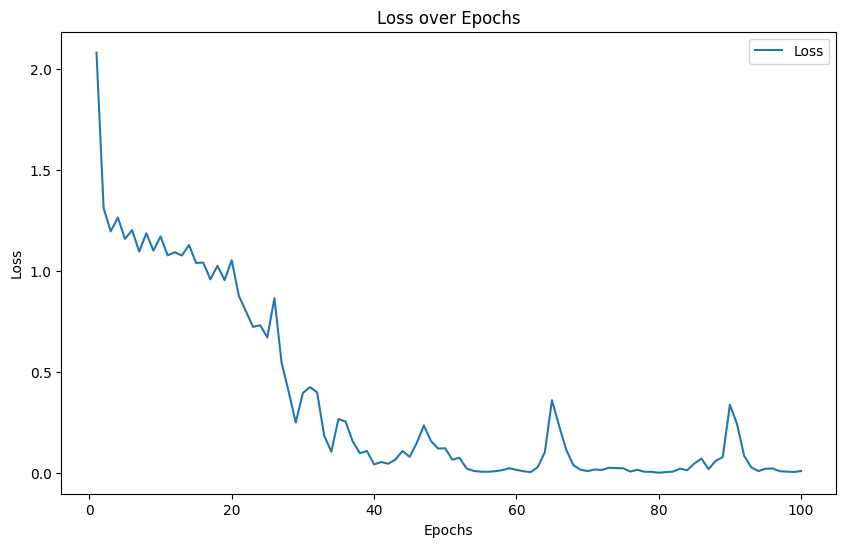

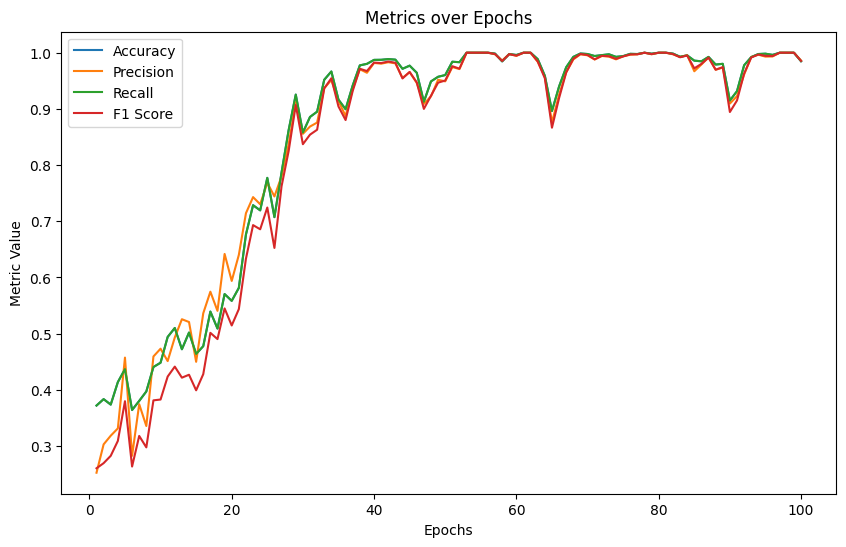

In [63]:
# plotting the result
def plot_metrics(metrics_history):
    epochs = range(1, len(metrics_history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics_history['loss'], label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy, Precision, Recall, F1 Score
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics_history['accuracy'], label='Accuracy')
    plt.plot(epochs, metrics_history['precision'], label='Precision')
    plt.plot(epochs, metrics_history['recall'], label='Recall')
    plt.plot(epochs, metrics_history['f1_score'], label='F1 Score')
    plt.title('Metrics over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()

plot_metrics(metrics_history)


In [64]:
# saving the model
torch.save(model.state_dict(), "fruit_ripeness_IP.pth")

In [70]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [71]:
# Validation function with confusion matrix
def validate_model(model, criterion, val_loader, class_names):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    accuracy_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    f1_total = 0.0
    total_samples = 0

    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No gradient computation during validation
        with tqdm(val_loader, desc="Validation", unit="batch") as vepoch:
            for inputs, labels in vepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                # Calculate each metric
                accuracy_total += accuracy_metric(preds, labels).item()
                precision_total += precision_metric(preds, labels).item()
                recall_total += recall_metric(preds, labels).item()
                f1_total += f1_metric(preds, labels).item()
                total_samples += 1

                # Store predictions and labels for confusion matrix
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update progress bar with current batch's averaged metrics
                vepoch.set_postfix(loss=running_loss / total_samples,
                                   accuracy=accuracy_total / total_samples,
                                   precision=precision_total / total_samples,
                                   recall=recall_total / total_samples,
                                   f1_score=f1_total / total_samples)

    # Calculate average metrics for the entire validation set
    avg_loss = running_loss / total_samples
    avg_accuracy = accuracy_total / total_samples
    avg_precision = precision_total / total_samples
    avg_recall = recall_total / total_samples
    avg_f1 = f1_total / total_samples

    print(f"Validation Results - Loss: {avg_loss:.4f}, "
          f"Accuracy: {avg_accuracy:.4f}, "
          f"Precision: {avg_precision:.4f}, "
          f"Recall: {avg_recall:.4f}, "
          f"F1 Score: {avg_f1:.4f}")

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(conf_matrix, class_names)

    


In [67]:
# Load the saved model state
model_prev = TransRes()  # Initialize your model class
model_prev.load_state_dict(torch.load('/kaggle/working/fruit_ripeness_IP.pth'))  
model_prev = model_prev.to(device)  # Move model to device

/tmp/ipykernel_30/1014751157.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_prev.load_state_dict(torch.load('/kaggle/working/fruit_ripeness_IP.pth'))  # Replace w

Validation:   0%|          | 0/6 [00:00<?, ?batch/s]

Validation Results - Loss: 0.9538, Accuracy: 0.7914, Precision: 0.8231, Recall: 0.7914, F1 Score: 0.7779


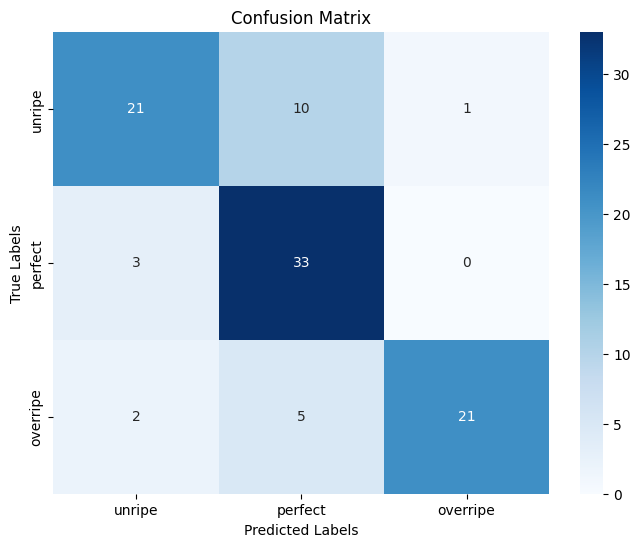

In [72]:
# After training the model, call the validation function
class_names = ['unripe', 'perfect', 'overripe']  # actual class names
validate_model(model, criterion, val_loader, class_names)